# Autoencoders

Welcome our treasured friends, PyTorch and TorchVision.

In [1]:
import torch
import torchvision

As we will be using image data, we need to define some preprocessing.

In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, ), (0.5, )),
])

We will be using the MNIST dataset today.

In [3]:
data = torchvision.datasets.MNIST(
    './',
    train=True,
    download=True,
    transform=transform)

Let's define a function to make Jupyter Notebook display our data.

In [4]:
from matplotlib.pyplot import imshow

def show_images(images):
    images = images.cpu()
    
    # Convert grayscale image into RGB channels.
    images = images.expand(-1, 3, -1, -1)
    
    # Make a grid view image of this batch.
    images = torchvision.utils.make_grid(images)
    
    # Unnormalize.
    images = images / 2 + 0.5
    
    # Convert PyTorch tensor to a NumPy array.
    images = images.numpy().transpose([1, 2, 0])
    
    # Display images.
    imshow(images)

Let's see how the data looks like!

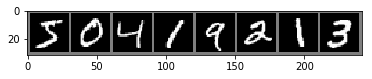

In [5]:
sample_batch = iter(torch.utils.data.DataLoader(
    data, shuffle=False, batch_size=8)).next()[0]
show_images(sample_batch)

Here's some idea of what we'll be building:
![](http://curiousily.com/assets/12.what_to_do_when_data_is_missing_part_ii_files/mushroom_encoder.png)

Let's define our encoder and decoder modules separately. Simple models can be created with `torch.nn.Sequential`, which saves the effort of defining a class.

In [6]:
encoder = torch.nn.Sequential(
    torch.nn.Conv2d(1, 16, 3, stride=3, padding=1), # (16, 10, 10)
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2, stride=2), # (16, 5, 5)
    torch.nn.Conv2d(16, 8, 3, stride=2, padding=1), # (8, 3, 3)
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2, stride=1) # (8, 2, 2)
)

decoder = torch.nn.Sequential(
    torch.nn.ConvTranspose2d(8, 16, 3, stride=2), # (16, 5, 5)
    torch.nn.ReLU(),
    torch.nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1), # (8, 15, 15)
    torch.nn.ReLU(),
    torch.nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1), # (1, 28, 28)
    torch.nn.Tanh()
)

Don't forget the loss function and the optimizer. As we have two models, we need to let the optimizer know both.

In [7]:
criterion = torch.nn.MSELoss()

from itertools import chain
parameters = chain(encoder.parameters(), decoder.parameters())
optimizer = torch.optim.Adam(parameters, lr=1e-3, weight_decay=1e-15)

Here's some speedup for the lucky ones who have a GPU:

In [8]:
GPU_ID = 2

if torch.cuda.is_available():
    print('Using CUDA')
    sample_batch = sample_batch.cuda(device=GPU_ID)
    encoder = encoder.cuda(device=GPU_ID)
    decoder = decoder.cuda(device=GPU_ID)

Using CUDA


Let's batchfiy our data now.

In [9]:
BATCH_SIZE = 512
NUM_WORKERS = 2
batches = torch.utils.data.DataLoader(
    dataset=data,
    shuffle=True,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
     drop_last=True)

Finally, let's get training!

In [10]:
NUM_EPOCHS = 32

for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    with torch.set_grad_enabled(True):
        for image, target in batches:
            if torch.cuda.is_available():
                image = image.cuda(device=GPU_ID)

            code = encoder(image)
            reconstruction = decoder(code)
            loss = criterion(reconstruction, image)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += float(loss)
            
    print(f'epoch {epoch}: loss {epoch_loss/len(batches):.3f}')

epoch 0: loss 0.658
epoch 1: loss 0.410
epoch 2: loss 0.375
epoch 3: loss 0.336
epoch 4: loss 0.315
epoch 5: loss 0.284
epoch 6: loss 0.260
epoch 7: loss 0.233
epoch 8: loss 0.222
epoch 9: loss 0.208
epoch 10: loss 0.179
epoch 11: loss 0.172
epoch 12: loss 0.167
epoch 13: loss 0.163
epoch 14: loss 0.160
epoch 15: loss 0.155
epoch 16: loss 0.152
epoch 17: loss 0.149
epoch 18: loss 0.147
epoch 19: loss 0.144
epoch 20: loss 0.142
epoch 21: loss 0.140
epoch 22: loss 0.138
epoch 23: loss 0.136
epoch 24: loss 0.135
epoch 25: loss 0.134
epoch 26: loss 0.133
epoch 27: loss 0.132
epoch 28: loss 0.131
epoch 29: loss 0.130
epoch 30: loss 0.129
epoch 31: loss 0.129


Let's see the trained results. Here are the sample batch that we extracted earlier:

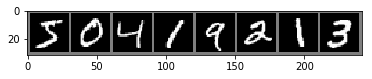

In [11]:
show_images(sample_batch)

And here are our autoencoder's reconstruction of them:

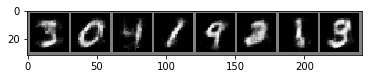

In [12]:
with torch.no_grad():
    show_images(decoder(encoder(sample_batch)))

## Denoising autoencoder

Autoencoders can also be used to denoise images.

![](https://cdn-images-1.medium.com/max/1040/1*SxwRp9i23OM0Up4sEze1QQ@2x.png)

First, we need to define the noise creating function:

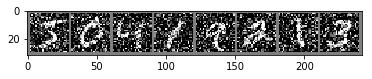

In [13]:
def add_noise(x):
    noise = torch.FloatTensor(x.size()).normal_(0, 1)
    if torch.cuda.is_available():
        noise = noise.cuda(device=GPU_ID)
    return (x + noise).clamp_(-1, 1)


noisy_sample = add_noise(sample_batch)
show_images(noisy_sample)

Let's start training!

In [14]:
NUM_EPOCHS = 64
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    with torch.set_grad_enabled(True):
        for image, target in batches:
            if torch.cuda.is_available():
                image = image.cuda(device=GPU_ID)
            
            noisy_image = add_noise(image)

            code = encoder(noisy_image)
            reconstruction = decoder(code)
            loss = criterion(reconstruction, image)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += float(loss)
            
    print(f'epoch {epoch}: loss {epoch_loss/len(batches):.3f}')

epoch 0: loss 0.177
epoch 1: loss 0.170
epoch 2: loss 0.168
epoch 3: loss 0.167
epoch 4: loss 0.166
epoch 5: loss 0.165
epoch 6: loss 0.164
epoch 7: loss 0.164
epoch 8: loss 0.163
epoch 9: loss 0.163
epoch 10: loss 0.163
epoch 11: loss 0.162
epoch 12: loss 0.162
epoch 13: loss 0.162
epoch 14: loss 0.162
epoch 15: loss 0.161
epoch 16: loss 0.161
epoch 17: loss 0.161
epoch 18: loss 0.161
epoch 19: loss 0.160
epoch 20: loss 0.160
epoch 21: loss 0.160
epoch 22: loss 0.160
epoch 23: loss 0.160
epoch 24: loss 0.160
epoch 25: loss 0.159
epoch 26: loss 0.159
epoch 27: loss 0.159
epoch 28: loss 0.159
epoch 29: loss 0.159
epoch 30: loss 0.159
epoch 31: loss 0.159
epoch 32: loss 0.158
epoch 33: loss 0.158
epoch 34: loss 0.158
epoch 35: loss 0.158
epoch 36: loss 0.158
epoch 37: loss 0.158
epoch 38: loss 0.158
epoch 39: loss 0.158
epoch 40: loss 0.158
epoch 41: loss 0.157
epoch 42: loss 0.157
epoch 43: loss 0.157
epoch 44: loss 0.157
epoch 45: loss 0.157
epoch 46: loss 0.157
epoch 47: loss 0.157
ep

Our noisy inputs were:

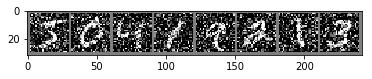

In [15]:
 show_images(noisy_sample)

The autoencoder have made them a bit better:

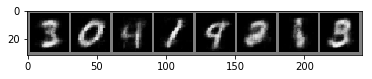

In [16]:
with torch.no_grad():
    show_images(decoder(encoder(noisy_sample)))